In [33]:
import rdkit
from rdkit.Chem import AllChem
import pandas as pd
import os
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit import Chem
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import DataStructs

In [34]:
import json
with open('../../sup_info/crossdock2020_duplicated_uniprotId_map_smiles_in_trainset.json','r') as f:
    crossdock2020_duplicated_uniprotId_map_smiles_in_trainset = json.load(f)

### 所有的数据加载分析

In [ ]:
pre_process_dir = 'the directory of pre-processed results from TAScore_preprocess.py'
save_dir = 'the directory to save the processed results from this script'
path_1 = f'{pre_process_dir}/Round1.csv'
path_2 = f'{pre_process_dir}/Round2.csv'
path_3 = f'{pre_process_dir}/Round3.csv'
round1 = pd.read_csv(path_1)
round2 = pd.read_csv(path_2)
round3 = pd.read_csv(path_3)


In [ ]:
def get_image_three_repeat_TAScore(round1,round2,round3,crossdock2020_duplicated_uniprotId_map_smiles_in_trainset,protein_type='all_protein',show_values=True,image_name=''):
    # 计算每个模型的 Scaffold 与 Smiles 的 Target Aware Score

    # ================== 变量计算（保留已有，仅补充清晰注释） ==================
    # 计算 pivot_scf_plot / pivot_smi_plot (从 round1/2/3 原始表得到 -> 按 (ModelName, UniprotID) 平均 -> 分箱 -> 归一化)
    from matplotlib.patches import Patch  # 后面需要用到图例 Patch

    # 1) 逐 round 计算 Target_Aware 分数
    _round_dfs = []
    for _r, _df in enumerate([round1, round2, round3], start=1):
        _tmp = _df[['ModelName', 'UniprotID',
                    'Scaffold2smiles_interaction_specific', 'Scaffold2smiles_interaction_all',
                    'smiles_interaction_specific', 'smiles_interaction_all']].copy()
        _tmp['Target_Aware_Score_Scaffolds'] = _tmp['Scaffold2smiles_interaction_specific'] / (_tmp['Scaffold2smiles_interaction_all'] + 1e-10)
        _tmp['Target_Aware_Score_Smiles'] = _tmp['smiles_interaction_specific'] / (_tmp['smiles_interaction_all'] + 1e-10)
        _tmp['Round'] = _r
        _round_dfs.append(_tmp)

    _all_rounds = pd.concat(_round_dfs, ignore_index=True)

    # 2) 过滤 targets（与下游保持一致）
    if protein_type =='all':
        image_name += '_all_protein'
        pass
    elif protein_type == 'seen':
        # 仅保留 crossdock2020 中的 UniprotID
        image_name += '_seen_protein'
        _all_rounds = _all_rounds[_all_rounds['UniprotID'].isin(crossdock2020_duplicated_uniprotId_map_smiles_in_trainset.keys())]
    elif protein_type == 'unseen':
        image_name += '_unseen_protein'
        # 仅保留 crossdock2020_duplicated_uniprotId_map_smiles_in_trainset 中的 UniprotID
        _all_rounds = _all_rounds[~_all_rounds['UniprotID'].isin(crossdock2020_duplicated_uniprotId_map_smiles_in_trainset.keys())]
    print('num of targets:', len(_all_rounds['UniprotID'].unique()))

    # 3) 跨 3 个 round 按 (ModelName, UniprotID) 求平均
    _avg_df = (_all_rounds
            .groupby(['ModelName', 'UniprotID'])[['Target_Aware_Score_Scaffolds', 'Target_Aware_Score_Smiles']]
            .mean()
            .reset_index())

    _df_scores = _avg_df[['ModelName', 'Target_Aware_Score_Scaffolds', 'Target_Aware_Score_Smiles']].copy()

    # 4) 分箱边界与标签
    _edges_base = [0.0, 1.0, 10.0, 100.0]
    _upper = float(np.nanmax([
        _df_scores['Target_Aware_Score_Scaffolds'].max(),
        _df_scores['Target_Aware_Score_Smiles'].max()
    ]))
    if _upper <= _edges_base[-1]:
        _upper = _edges_base[-1] + 1.0

    _upper_int = int(np.ceil(_upper))
    _bin_edges = np.array(_edges_base + [_upper_int], dtype=float)
    valid_cols = [
        f"{int(_bin_edges[i])}-{int(_bin_edges[i+1] if i < len(_bin_edges)-2 else _upper_int)}"
        for i in range(len(_bin_edges) - 1)
    ]
    print('bin edges:', _bin_edges)
    print('valid cols:', valid_cols)
    print('upper value:', _upper)
    # 5) 分箱
    _cats_scf = pd.cut(_df_scores['Target_Aware_Score_Scaffolds'],
                    bins=_bin_edges, labels=valid_cols, right=False, include_lowest=True)
    _cats_smi = pd.cut(_df_scores['Target_Aware_Score_Smiles'],
                    bins=_bin_edges, labels=valid_cols, right=False, include_lowest=True)

    # 6) 统计并标准化
    _counts_scf = _df_scores.groupby(['ModelName', _cats_scf]).size().unstack(fill_value=0)
    _counts_smi = _df_scores.groupby(['ModelName', _cats_smi]).size().unstack(fill_value=0)
    ## 计算总的靶点数，如果有些方法靶点数不够，则将这个数量算在0-1的bin中
    all_targets_num = len(_all_rounds['UniprotID'].unique())

    for _lab in valid_cols:
        if _lab not in _counts_scf.columns:
            _counts_scf[_lab] = 0
            print('add missing col to scf:', _lab)
        if _lab not in _counts_smi.columns:
            _counts_smi[_lab] = 0
            print('add missing col to smi:', _lab)
    if '0-1' in _counts_scf.columns:
        _counts_scf['0-1'] += (all_targets_num - _counts_scf.sum(axis=1)).clip(lower=0)
    if '0-1' in _counts_smi.columns:
        _counts_smi['0-1'] += (all_targets_num - _counts_smi.sum(axis=1)).clip(lower=0)
    print(_counts_scf )
    print(_counts_smi )
    _counts_scf = _counts_scf[valid_cols]
    _counts_smi = _counts_smi[valid_cols]
    # def _round_sig(df, sig=3):
        # return df.applymap(lambda x: float(f"{x:.{sig}g}") if pd.notnull(x) else x)

    # pivot_scf_plot = _round_sig(_counts_scf.div(_counts_scf.sum(axis=1), axis=0)).fillna(0)
    # pivot_smi_plot = _round_sig(_counts_smi.div(_counts_smi.sum(axis=1), axis=0)).fillna(0)
    # 
    pivot_scf_plot = _counts_scf.div(_counts_scf.sum(axis=1), axis=0).fillna(0)
    pivot_smi_plot = _counts_smi.div(_counts_smi.sum(axis=1), axis=0).fillna(0)
    # ================== 变量计算（保留已有，仅补充清晰注释） ==================
    # order 已基于 pivot_scf_plot['0-1'] 降序得出
    order = pivot_scf_plot.sort_values(by='0-1', ascending=False).index.tolist()

    # 重新对齐排序后的 DataFrame
    pivot_scf_sorted = pivot_scf_plot.loc[order]
    pivot_smi_sorted = pivot_smi_plot.loc[order]

    models = order                      # 模型名称顺序
    n_models = len(models)              # 模型数
    y = np.arange(n_models)             # 每个模型的 y 位置
    h = 0.38                            # 条形高度 (Scaffold 与 Smiles 两条水平条分上下)

    # 颜色：与区间数保持一致
    # if 'colors' not in globals() or len(colors) != len(valid_cols):
    colors = sns.color_palette("Set2", n_colors=len(valid_cols))

    # --- 绘图 ---
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(10, 0.6*n_models + 1))

    # 堆积起点
    bscf = np.zeros(n_models)
    bsmi = np.zeros(n_models)

    # 逐区间堆积绘制
    for i, lab in enumerate(valid_cols):
        vals_scf = pivot_scf_sorted[lab].values
        vals_smi = pivot_smi_sorted[lab].values

        ax.barh(y - h/2, vals_scf, left=bscf, height=h,
                color=colors[i], alpha=0.75, edgecolor='blue', linewidth=0.4)
        ax.barh(y + h/2, vals_smi, left=bsmi, height=h,
                color=colors[i], alpha=0.75, hatch='/', edgecolor='blue', linewidth=0.4)

        bscf += vals_scf
        bsmi += vals_smi

    # 统一 x 轴范围 (堆积比例和为 1；稍微留白)
    ax.set_xlim(0, 1.05)

    # ================== 数值标签新的展示策略 ==================
    # 对每一行(模型)分别在 Scaffold 行(y - h/2) 与 Smiles 行(y + h/2) 内部等间距放置所有区间的数值
    n_intervals = len(valid_cols)
    # 在 (0.02, 0.98) 范围内等间距生成放置点，避免紧贴左右边界
    x_positions = np.linspace(0.08, 0.92, n_intervals)

    # 字体与格式
    fmt = lambda v: f"{v:.4f}"
    if show_values:
        image_name += '_values_inline_order'
        # Scaffold 数值
        for row_idx, model in enumerate(models):
            row_vals = pivot_scf_sorted.loc[model, valid_cols].values
            for j, v in enumerate(row_vals):
                
                ax.text(x_positions[j], y[row_idx] - h/2, fmt(v),
                        ha='center', va='center', fontsize=8, color='black')

        # Smiles 数值
        for row_idx, model in enumerate(models):
            row_vals = pivot_smi_sorted.loc[model, valid_cols].values
            for j, v in enumerate(row_vals):
        
                ax.text(x_positions[j], y[row_idx] + h/2, fmt(v),
                        ha='center', va='center', fontsize=8, color='black')

    # ================== 轴与图例 ==================
    ax.set_yticks(y)
    ax.set_yticklabels(models)
    ax.set_xlabel('Proportion')
    ax.set_title(f'Average over 3 Rounds ({protein_type})\nScaffold vs SMILES by Score Intervals (Sorted by Scaffold 0-1 Desc)')

    interval_handles = [Patch(facecolor=colors[i], label=lab) for i, lab in enumerate(valid_cols)]
    ax.legend(handles=interval_handles, title='Score Intervals',
            loc='upper left', bbox_to_anchor=(1.02, 1.0), borderaxespad=0.)

    fig.tight_layout()
    plt.savefig(f'{save_dir}/target_aware_score_{image_name}.svg',
                bbox_inches='tight', dpi=600, format='svg')
    if protein_type == 'all' and show_values:
        _df_scores.to_csv(f'{save_dir}/target_aware_score_{image_name}.csv',index = False)
        
    plt.show()
    return pivot_scf_plot, pivot_smi_plot, _df_scores


In [ ]:
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns

def get_image_three_repeat_TAScore_counts(
    round1, round2, round3,
    crossdock2020_duplicated_uniprotId_map_smiles_in_trainset,
    protein_type='all',
    show_values=True,
    image_name=''):
    """
    修复版：
    1. 修正循环缩进错误（之前只画出最后一个区间，导致显示不全）
    2. 去掉人为把每个模型缺少的 target 数量补到 0-1 桶里的逻辑（那会造假）
    3. x 轴长度按各模型真实总 target 数最大值 *1.05
    返回：pivot_scf_counts, pivot_smi_counts, _df_scores
    """
    import matplotlib.pyplot as plt

    # 1) 逐 round 计算 Target Aware Score
    _round_dfs = []
    for _r, _df in enumerate([round1, round2, round3], start=1):
        _tmp = _df[['ModelName', 'UniprotID',
                    'Scaffold2smiles_interaction_specific', 'Scaffold2smiles_interaction_all',
                    'smiles_interaction_specific', 'smiles_interaction_all']].copy()
        _tmp['Target_Aware_Score_Scaffolds'] = _tmp['Scaffold2smiles_interaction_specific'] / (_tmp['Scaffold2smiles_interaction_all'] + 1e-10)
        _tmp['Target_Aware_Score_Smiles'] = _tmp['smiles_interaction_specific'] / (_tmp['smiles_interaction_all'] + 1e-10)
        _tmp['Round'] = _r
        _round_dfs.append(_tmp)
    _all_rounds = pd.concat(_round_dfs, ignore_index=True)

    # 2) 过滤 target
    if protein_type == 'all':
        image_name += '_all_protein'
    elif protein_type == 'seen':
        image_name += '_seen_protein'
        _all_rounds = _all_rounds[_all_rounds['UniprotID'].isin(
            crossdock2020_duplicated_uniprotId_map_smiles_in_trainset.keys())]
    elif protein_type == 'unseen':
        image_name += '_unseen_protein'
        _all_rounds = _all_rounds[~_all_rounds['UniprotID'].isin(
            crossdock2020_duplicated_uniprotId_map_smiles_in_trainset.keys())]
    print('num of targets:', len(_all_rounds['UniprotID'].unique()))

    # 3) 按 (ModelName, UniprotID) 平均三个 round
    _avg_df = (_all_rounds
               .groupby(['ModelName', 'UniprotID'])[['Target_Aware_Score_Scaffolds', 'Target_Aware_Score_Smiles']]
               .mean()
               .reset_index())
    _df_scores = _avg_df[['ModelName', 'Target_Aware_Score_Scaffolds', 'Target_Aware_Score_Smiles']].copy()

    # 4) 动态分箱
    _edges_base = [0.0, 1.0, 10.0, 100.0]
    _upper = float(np.nanmax([
        _df_scores['Target_Aware_Score_Scaffolds'].max(),
        _df_scores['Target_Aware_Score_Smiles'].max()
    ]))
    if _upper <= _edges_base[-1]:
        _upper = _edges_base[-1] + 1.0
    _upper_int = int(np.ceil(_upper))
    _bin_edges = np.array(_edges_base + [_upper_int], dtype=float)
    valid_cols = [f"{int(_bin_edges[i])}-{int(_bin_edges[i+1])}" for i in range(len(_bin_edges) - 1)]
    print('bin edges:', _bin_edges)
    print('valid cols:', valid_cols)

    # 5) 分箱
    _cats_scf = pd.cut(_df_scores['Target_Aware_Score_Scaffolds'],
                       bins=_bin_edges, labels=valid_cols, right=False, include_lowest=True)
    _cats_smi = pd.cut(_df_scores['Target_Aware_Score_Smiles'],
                       bins=_bin_edges, labels=valid_cols, right=False, include_lowest=True)

    # 6) 统计计数
    _counts_scf = _df_scores.groupby(['ModelName', _cats_scf]).size().unstack(fill_value=0)
    _counts_smi = _df_scores.groupby(['ModelName', _cats_smi]).size().unstack(fill_value=0)
    all_targets_num = len(_all_rounds['UniprotID'].unique())
    # 补全缺失列
    for _lab in valid_cols:
        if _lab not in _counts_scf.columns:
            _counts_scf[_lab] = 0
        if _lab not in _counts_smi.columns:
            _counts_smi[_lab] = 0
    if '0-1' in _counts_scf.columns:
        _counts_scf['0-1'] += (all_targets_num - _counts_scf.sum(axis=1)).clip(lower=0)
    if '0-1' in _counts_smi.columns:
        _counts_smi['0-1'] += (all_targets_num - _counts_smi.sum(axis=1)).clip(lower=0)

    # 只保留并按列顺序
    _counts_scf = _counts_scf[valid_cols]
    _counts_smi = _counts_smi[valid_cols]

    pivot_scf_plot = _counts_scf.copy()
    pivot_smi_plot = _counts_smi.copy()

    # 排序依据：Scaffold 的 0-1 bin 计数降序
    order = pivot_scf_plot.sort_values(by=valid_cols[0], ascending=False).index.tolist()
    pivot_scf_sorted = pivot_scf_plot.loc[order]
    pivot_smi_sorted = pivot_smi_plot.loc[order]

    models = order
    n_models = len(models)
    y = np.arange(n_models)
    h = 0.38

    colors = sns.color_palette("Set2", n_colors=len(valid_cols))
    fig, ax = plt.subplots(figsize=(10, 0.6 * n_models + 1))

    bscf = np.zeros(n_models, dtype=float)
    bsmi = np.zeros(n_models, dtype=float)

    # 真实每个模型 target 总数
    model_target_counts = pivot_scf_sorted.sum(axis=1)
    xmax = model_target_counts.max() * 1.05

    # 7) 堆积条形（修复：循环内绘图与累加）
    for i, lab in enumerate(valid_cols):
        vals_scf = pivot_scf_sorted[lab].values.astype(float)
        vals_smi = pivot_smi_sorted[lab].values.astype(float)

        ax.barh(y - h / 2, vals_scf, left=bscf, height=h,
                color=colors[i], alpha=0.85, edgecolor='blue', linewidth=0.4)
        ax.barh(y + h / 2, vals_smi, left=bsmi, height=h,
                color=colors[i], alpha=0.85, hatch='/', edgecolor='blue', linewidth=0.4)

        if show_values:
            centers_scf = bscf + vals_scf / 2
            centers_smi = bsmi + vals_smi / 2
            for r_idx, v in enumerate(vals_scf):
                if v > 0:
                    ax.text(centers_scf[r_idx], y[r_idx] - h / 2, f"{int(v)}",
                            ha='center', va='center', fontsize=8, color='black')
            for r_idx, v in enumerate(vals_smi):
                if v > 0:
                    ax.text(centers_smi[r_idx], y[r_idx] + h / 2, f"{int(v)}",
                            ha='center', va='center', fontsize=8, color='black')

        bscf += vals_scf
        bsmi += vals_smi

    ax.set_xlim(0, xmax)
    ax.set_yticks(y)
    ax.set_yticklabels(models)
    ax.set_xlabel('Count')
    ax.set_title(f'Average over 3 Rounds ({protein_type})\nScaffold vs SMILES Count by Score Intervals (Stacked)')

    interval_handles = [Patch(facecolor=colors[i], label=lab) for i, lab in enumerate(valid_cols)]
    ax.legend(handles=interval_handles, title='Score Intervals',
              loc='upper left', bbox_to_anchor=(1.02, 1.0), borderaxespad=0.)

    fig.tight_layout()
    image_name += '_counts_with_values' if show_values else '_counts'
    out_fig = f'{save_dir}/target_aware_score_{image_name}.svg'
    plt.savefig(out_fig, bbox_inches='tight', dpi=600, format='svg')
    if protein_type == 'all' and show_values:
        _df_scores.to_csv(f'{save_dir}/target_aware_score_{image_name}.csv',
                          index=False)
    plt.show()

    return pivot_scf_plot, pivot_smi_plot, _df_scores


num of targets: 85
bin edges: [  0.   1.  10. 100. 117.]
valid cols: ['0-1', '1-10', '10-100', '100-117']
upper value: 116.89242724132707
Target_Aware_Score_Scaffolds  0-1  1-10  10-100  100-117
ModelName                                               
DecompDiff                     49    35       1        0
FLAG                           59    26       0        0
MolCraft                       52    33       0        0
Pocket2Mol                     44    41       0        0
PocketFlow                     23    61       1        0
SurfGen                        52    25       8        0
TamGen                         58    27       0        0
TargetDiff                     33    51       1        0
diffSBDD_cond_crossdocked      42    42       1        0
diffSBDD_cond_moad             44    40       1        0
Target_Aware_Score_Smiles  0-1  1-10  10-100  100-117
ModelName                                            
DecompDiff                  82     2       1        0
FLAG            

/tmp/ipykernel_3577838/2839087403.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_scf = _df_scores.groupby(['ModelName', _cats_scf]).size().unstack(fill_value=0)
/tmp/ipykernel_3577838/2839087403.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_smi = _df_scores.groupby(['ModelName', _cats_smi]).size().unstack(fill_value=0)


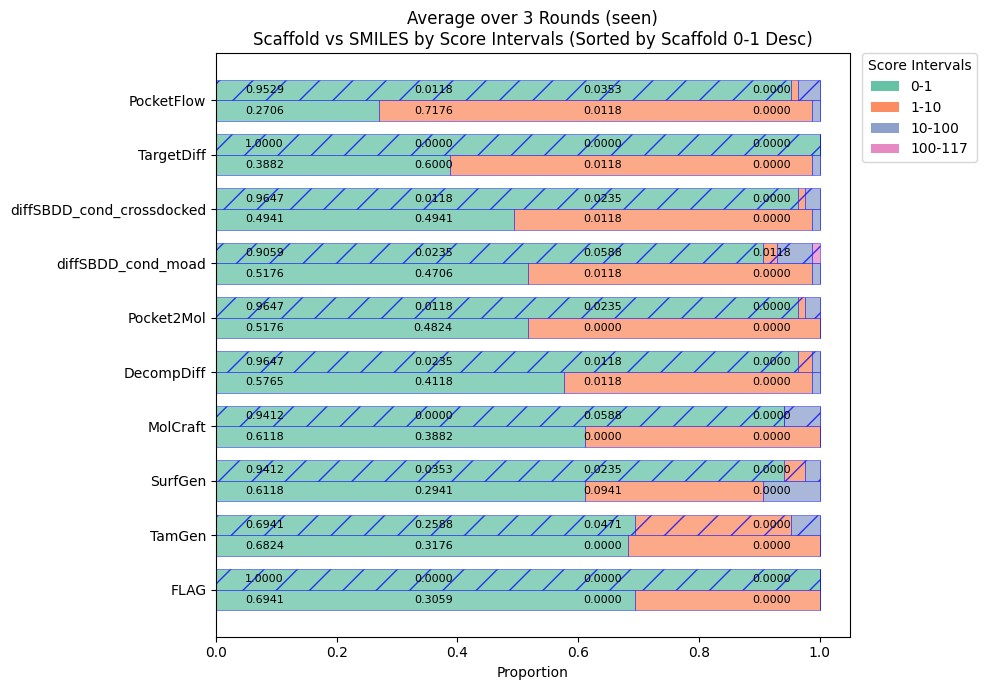

num of targets: 85
bin edges: [  0.   1.  10. 100. 117.]
valid cols: ['0-1', '1-10', '10-100', '100-117']
upper value: 116.89242724132707
Target_Aware_Score_Scaffolds  0-1  1-10  10-100  100-117
ModelName                                               
DecompDiff                     49    35       1        0
FLAG                           59    26       0        0
MolCraft                       52    33       0        0
Pocket2Mol                     44    41       0        0
PocketFlow                     23    61       1        0
SurfGen                        52    25       8        0
TamGen                         58    27       0        0
TargetDiff                     33    51       1        0
diffSBDD_cond_crossdocked      42    42       1        0
diffSBDD_cond_moad             44    40       1        0
Target_Aware_Score_Smiles  0-1  1-10  10-100  100-117
ModelName                                            
DecompDiff                  82     2       1        0
FLAG            

/tmp/ipykernel_3577838/2839087403.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_scf = _df_scores.groupby(['ModelName', _cats_scf]).size().unstack(fill_value=0)
/tmp/ipykernel_3577838/2839087403.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_smi = _df_scores.groupby(['ModelName', _cats_smi]).size().unstack(fill_value=0)


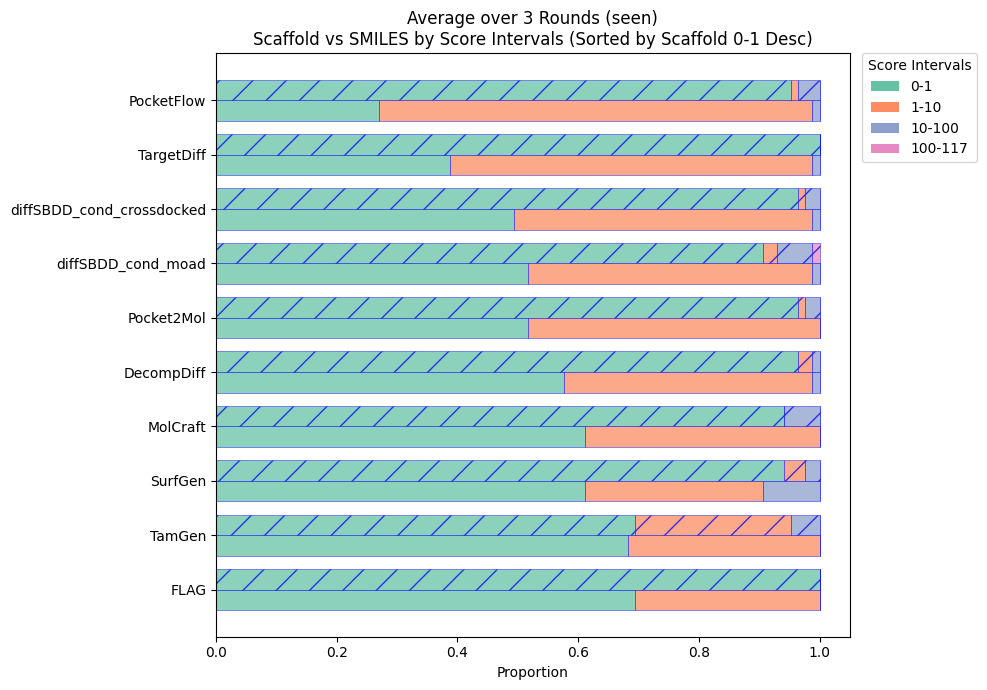

num of targets: 35
bin edges: [  0.   1.  10. 100. 105.]
valid cols: ['0-1', '1-10', '10-100', '100-105']
upper value: 104.88356219292841
Target_Aware_Score_Scaffolds  0-1  1-10  10-100  100-105
ModelName                                               
DecompDiff                     24    11       0        0
FLAG                           21    14       0        0
MolCraft                       23    12       0        0
Pocket2Mol                     24    11       0        0
PocketFlow                     10    25       0        0
SurfGen                        24    10       1        0
TamGen                         22    13       0        0
TargetDiff                     18    17       0        0
diffSBDD_cond_crossdocked      27     8       0        0
diffSBDD_cond_moad             22    13       0        0
Target_Aware_Score_Smiles  0-1  1-10  10-100  100-105
ModelName                                            
DecompDiff                  35     0       0        0
FLAG            

/tmp/ipykernel_3577838/2839087403.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_scf = _df_scores.groupby(['ModelName', _cats_scf]).size().unstack(fill_value=0)
/tmp/ipykernel_3577838/2839087403.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_smi = _df_scores.groupby(['ModelName', _cats_smi]).size().unstack(fill_value=0)


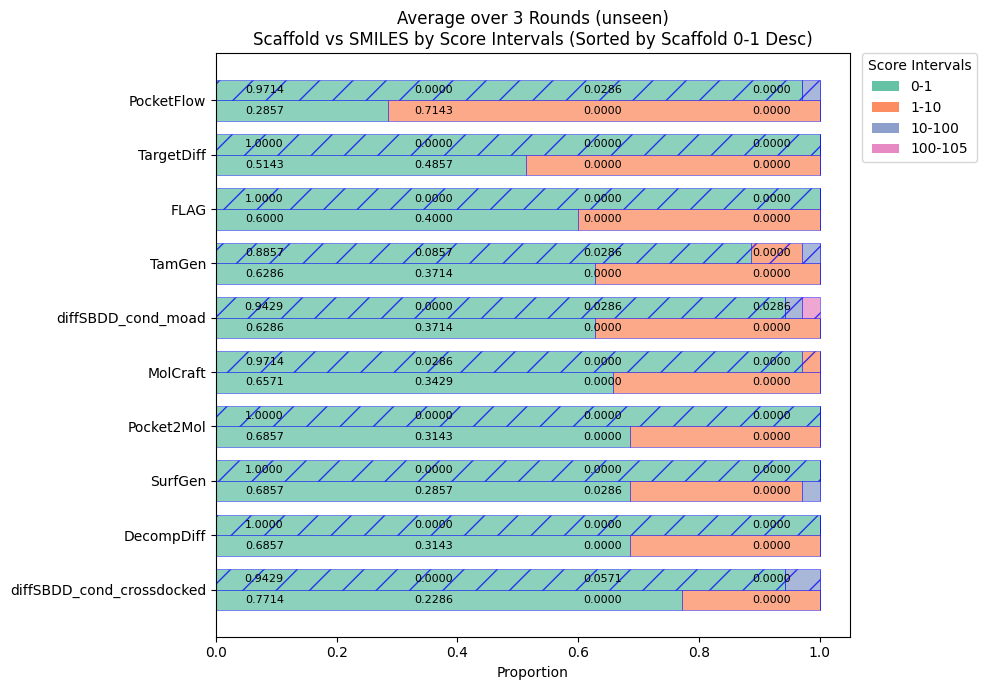

num of targets: 35
bin edges: [  0.   1.  10. 100. 105.]
valid cols: ['0-1', '1-10', '10-100', '100-105']
upper value: 104.88356219292841
Target_Aware_Score_Scaffolds  0-1  1-10  10-100  100-105
ModelName                                               
DecompDiff                     24    11       0        0
FLAG                           21    14       0        0
MolCraft                       23    12       0        0
Pocket2Mol                     24    11       0        0
PocketFlow                     10    25       0        0
SurfGen                        24    10       1        0
TamGen                         22    13       0        0
TargetDiff                     18    17       0        0
diffSBDD_cond_crossdocked      27     8       0        0
diffSBDD_cond_moad             22    13       0        0
Target_Aware_Score_Smiles  0-1  1-10  10-100  100-105
ModelName                                            
DecompDiff                  35     0       0        0
FLAG            

/tmp/ipykernel_3577838/2839087403.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_scf = _df_scores.groupby(['ModelName', _cats_scf]).size().unstack(fill_value=0)
/tmp/ipykernel_3577838/2839087403.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_smi = _df_scores.groupby(['ModelName', _cats_smi]).size().unstack(fill_value=0)


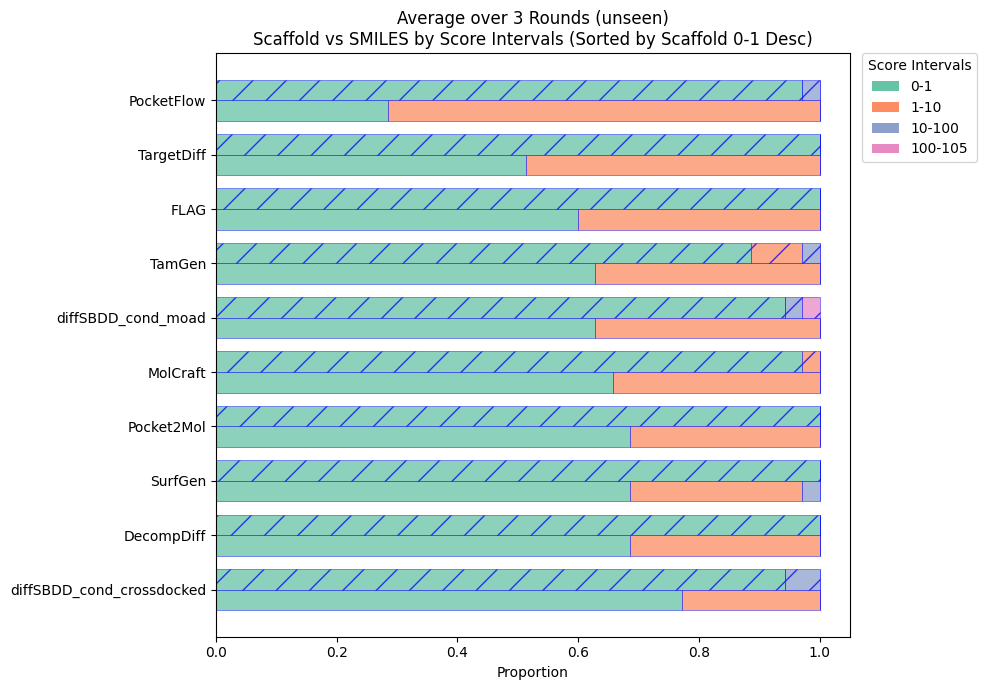

num of targets: 120
bin edges: [  0.   1.  10. 100. 117.]
valid cols: ['0-1', '1-10', '10-100', '100-117']
upper value: 116.89242724132707
Target_Aware_Score_Scaffolds  0-1  1-10  10-100  100-117
ModelName                                               
DecompDiff                     73    46       1        0
FLAG                           80    40       0        0
MolCraft                       75    45       0        0
Pocket2Mol                     68    52       0        0
PocketFlow                     33    86       1        0
SurfGen                        76    35       9        0
TamGen                         80    40       0        0
TargetDiff                     51    68       1        0
diffSBDD_cond_crossdocked      69    50       1        0
diffSBDD_cond_moad             66    53       1        0
Target_Aware_Score_Smiles  0-1  1-10  10-100  100-117
ModelName                                            
DecompDiff                 117     2       1        0
FLAG           

/tmp/ipykernel_3577838/2839087403.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_scf = _df_scores.groupby(['ModelName', _cats_scf]).size().unstack(fill_value=0)
/tmp/ipykernel_3577838/2839087403.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_smi = _df_scores.groupby(['ModelName', _cats_smi]).size().unstack(fill_value=0)


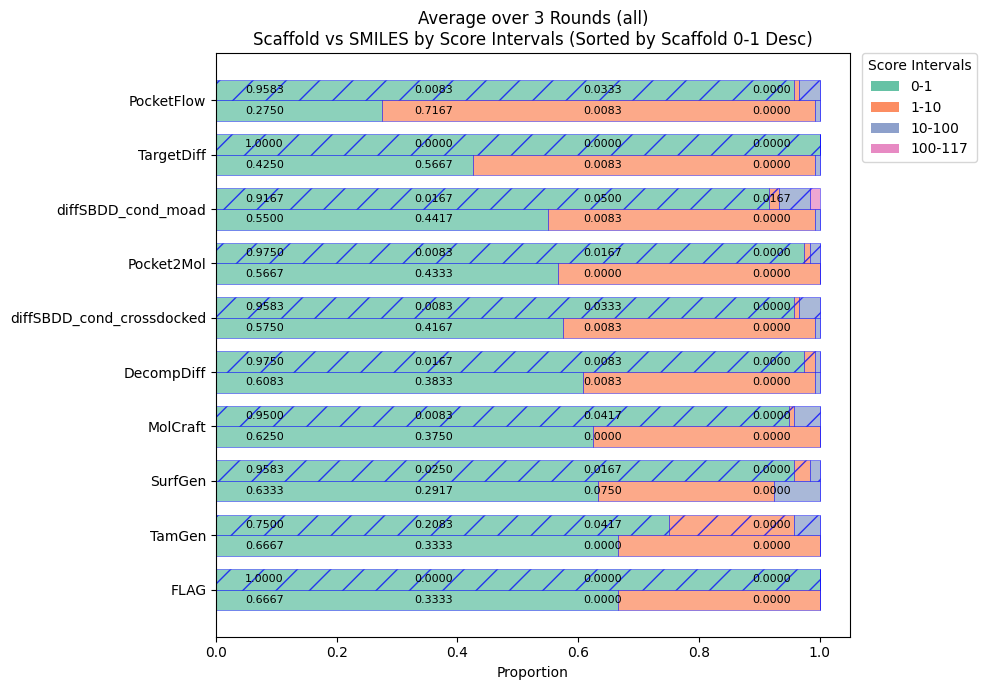

num of targets: 120
bin edges: [  0.   1.  10. 100. 117.]
valid cols: ['0-1', '1-10', '10-100', '100-117']
upper value: 116.89242724132707
Target_Aware_Score_Scaffolds  0-1  1-10  10-100  100-117
ModelName                                               
DecompDiff                     73    46       1        0
FLAG                           80    40       0        0
MolCraft                       75    45       0        0
Pocket2Mol                     68    52       0        0
PocketFlow                     33    86       1        0
SurfGen                        76    35       9        0
TamGen                         80    40       0        0
TargetDiff                     51    68       1        0
diffSBDD_cond_crossdocked      69    50       1        0
diffSBDD_cond_moad             66    53       1        0
Target_Aware_Score_Smiles  0-1  1-10  10-100  100-117
ModelName                                            
DecompDiff                 117     2       1        0
FLAG           

/tmp/ipykernel_3577838/2839087403.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_scf = _df_scores.groupby(['ModelName', _cats_scf]).size().unstack(fill_value=0)
/tmp/ipykernel_3577838/2839087403.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_smi = _df_scores.groupby(['ModelName', _cats_smi]).size().unstack(fill_value=0)


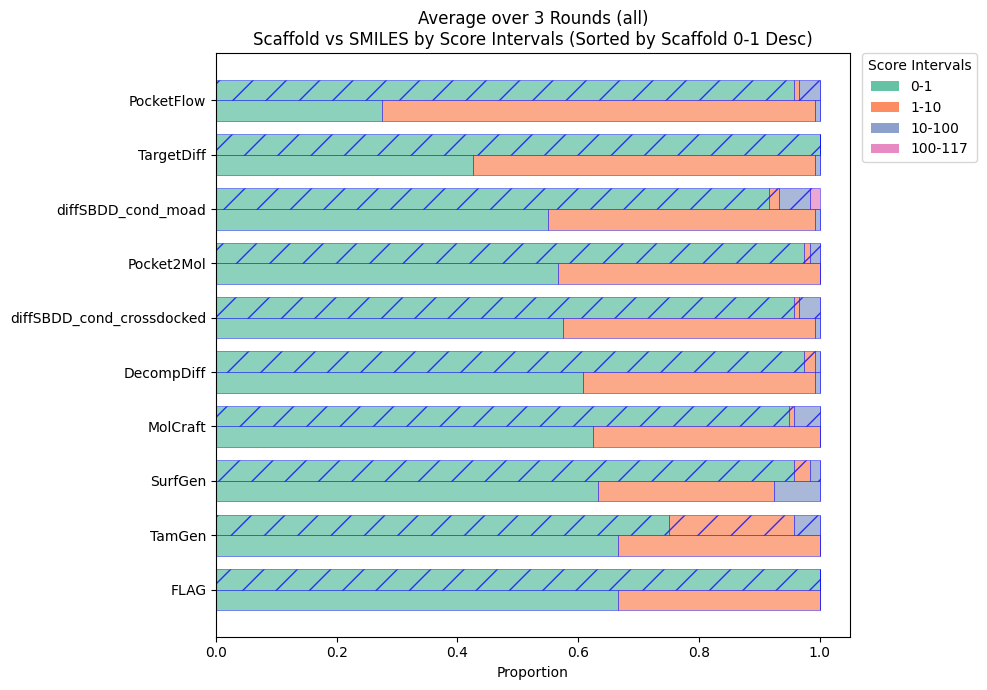

In [ ]:
for protein_type in ['seen', 'unseen','all']:

    for show_values in [True, False]:
        pivot_scf_plot, pivot_smi_plot, _df_scores = get_image_three_repeat_TAScore(round1,round2,round3,crossdock2020_duplicated_uniprotId_map_smiles_in_trainset,protein_type=protein_type,show_values=show_values,image_name='')

num of targets: 85
bin edges: [  0.   1.  10. 100. 117.]
valid cols: ['0-1', '1-10', '10-100', '100-117']


/tmp/ipykernel_3577838/3588268261.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_scf = _df_scores.groupby(['ModelName', _cats_scf]).size().unstack(fill_value=0)
/tmp/ipykernel_3577838/3588268261.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_smi = _df_scores.groupby(['ModelName', _cats_smi]).size().unstack(fill_value=0)


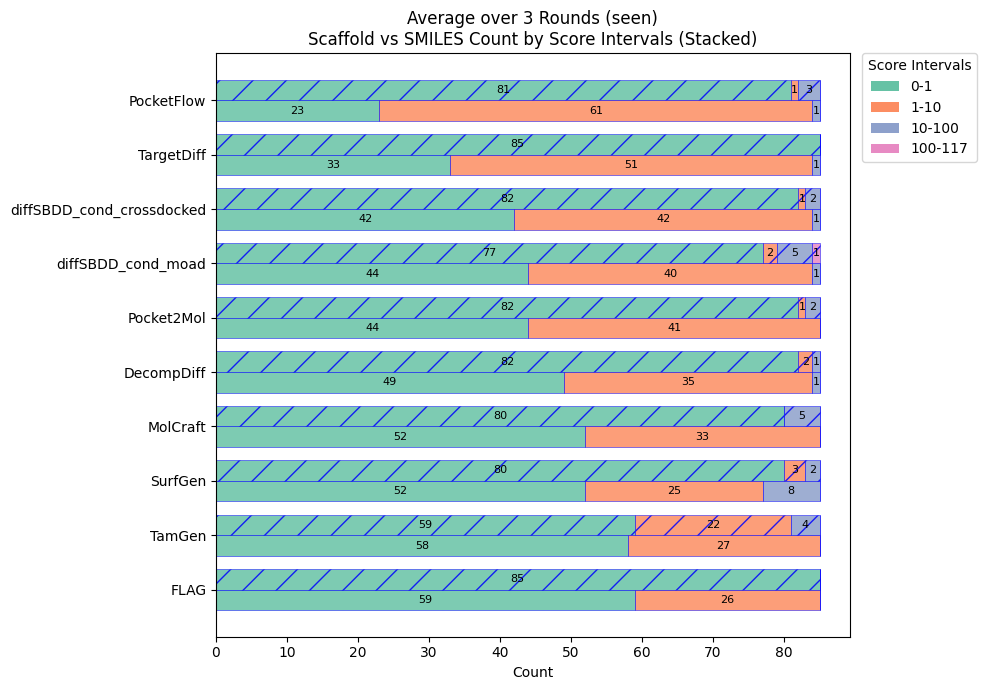

num of targets: 85
bin edges: [  0.   1.  10. 100. 117.]
valid cols: ['0-1', '1-10', '10-100', '100-117']


/tmp/ipykernel_3577838/3588268261.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_scf = _df_scores.groupby(['ModelName', _cats_scf]).size().unstack(fill_value=0)
/tmp/ipykernel_3577838/3588268261.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_smi = _df_scores.groupby(['ModelName', _cats_smi]).size().unstack(fill_value=0)


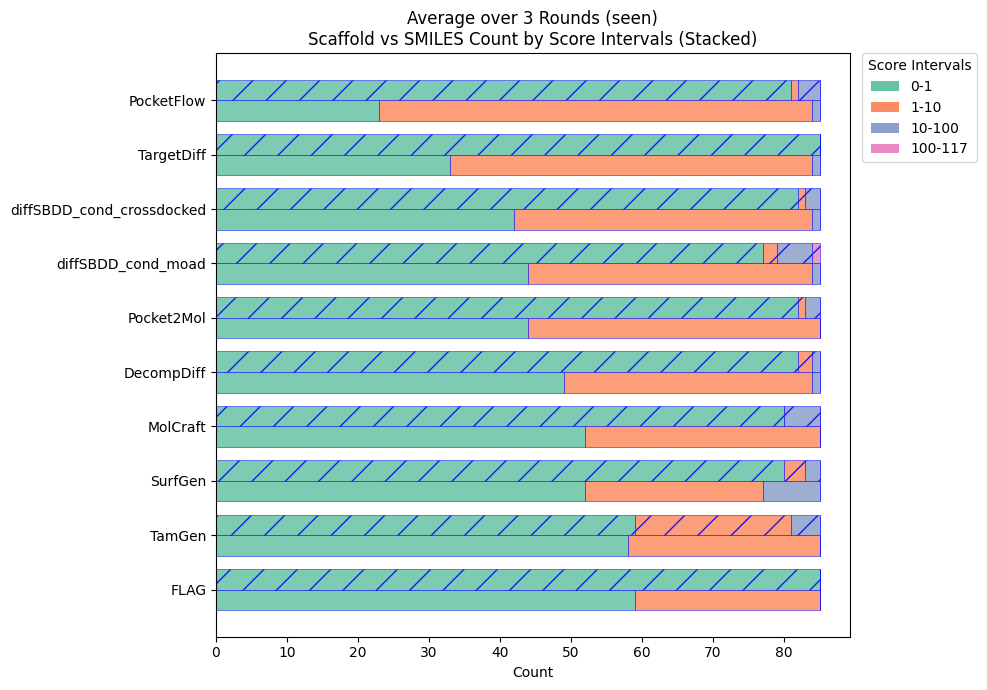

num of targets: 35
bin edges: [  0.   1.  10. 100. 105.]
valid cols: ['0-1', '1-10', '10-100', '100-105']


/tmp/ipykernel_3577838/3588268261.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_scf = _df_scores.groupby(['ModelName', _cats_scf]).size().unstack(fill_value=0)
/tmp/ipykernel_3577838/3588268261.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_smi = _df_scores.groupby(['ModelName', _cats_smi]).size().unstack(fill_value=0)


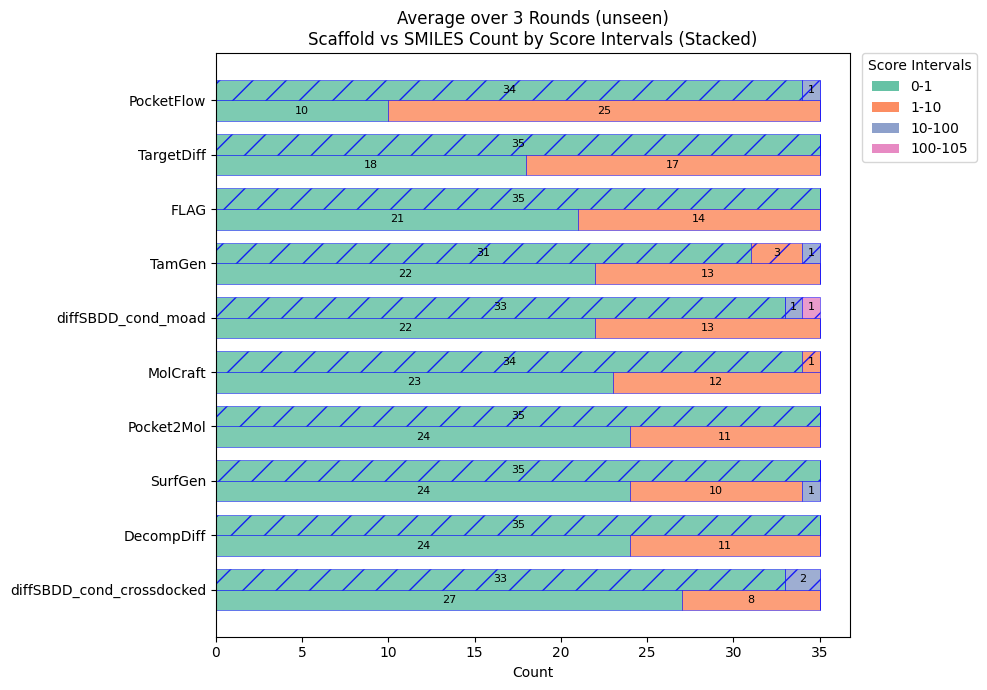

num of targets: 35
bin edges: [  0.   1.  10. 100. 105.]
valid cols: ['0-1', '1-10', '10-100', '100-105']


/tmp/ipykernel_3577838/3588268261.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_scf = _df_scores.groupby(['ModelName', _cats_scf]).size().unstack(fill_value=0)
/tmp/ipykernel_3577838/3588268261.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_smi = _df_scores.groupby(['ModelName', _cats_smi]).size().unstack(fill_value=0)


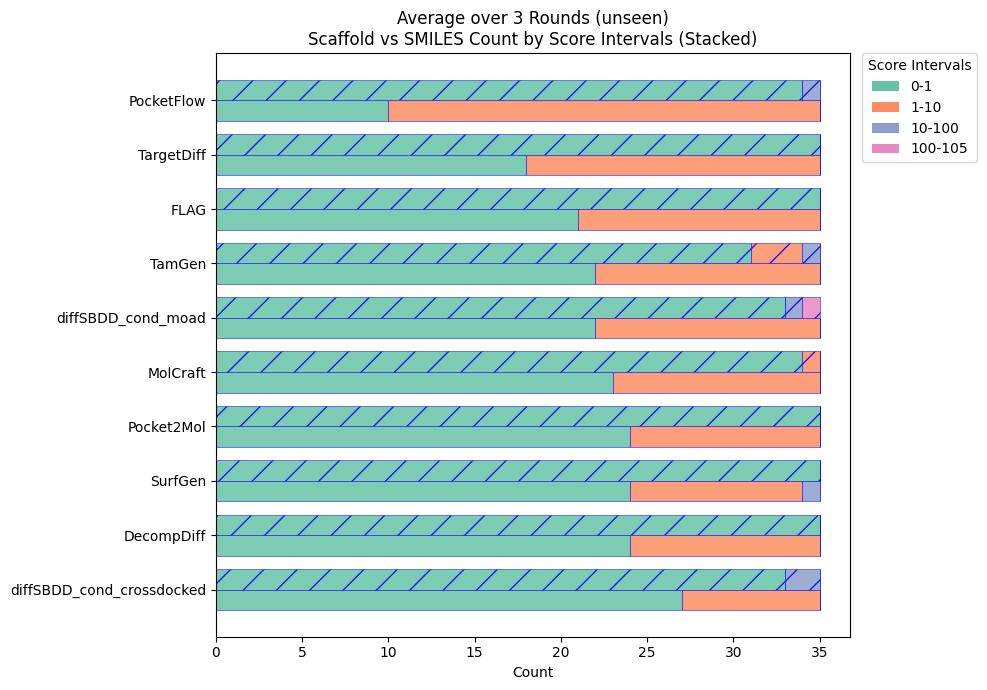

num of targets: 120
bin edges: [  0.   1.  10. 100. 117.]
valid cols: ['0-1', '1-10', '10-100', '100-117']


/tmp/ipykernel_3577838/3588268261.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_scf = _df_scores.groupby(['ModelName', _cats_scf]).size().unstack(fill_value=0)
/tmp/ipykernel_3577838/3588268261.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_smi = _df_scores.groupby(['ModelName', _cats_smi]).size().unstack(fill_value=0)


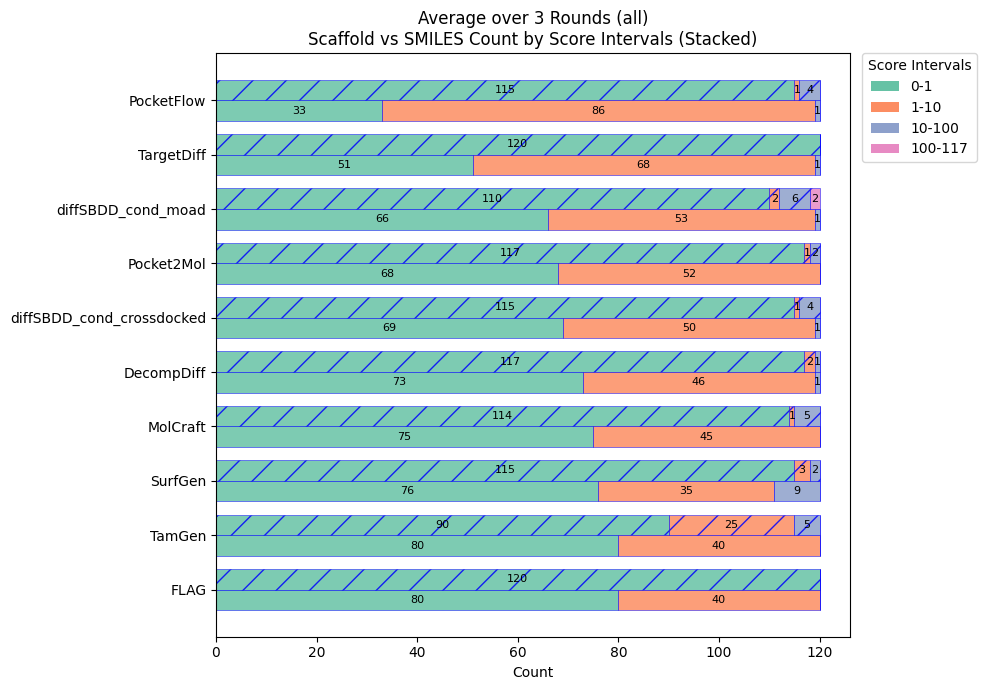

num of targets: 120
bin edges: [  0.   1.  10. 100. 117.]
valid cols: ['0-1', '1-10', '10-100', '100-117']


/tmp/ipykernel_3577838/3588268261.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_scf = _df_scores.groupby(['ModelName', _cats_scf]).size().unstack(fill_value=0)
/tmp/ipykernel_3577838/3588268261.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _counts_smi = _df_scores.groupby(['ModelName', _cats_smi]).size().unstack(fill_value=0)


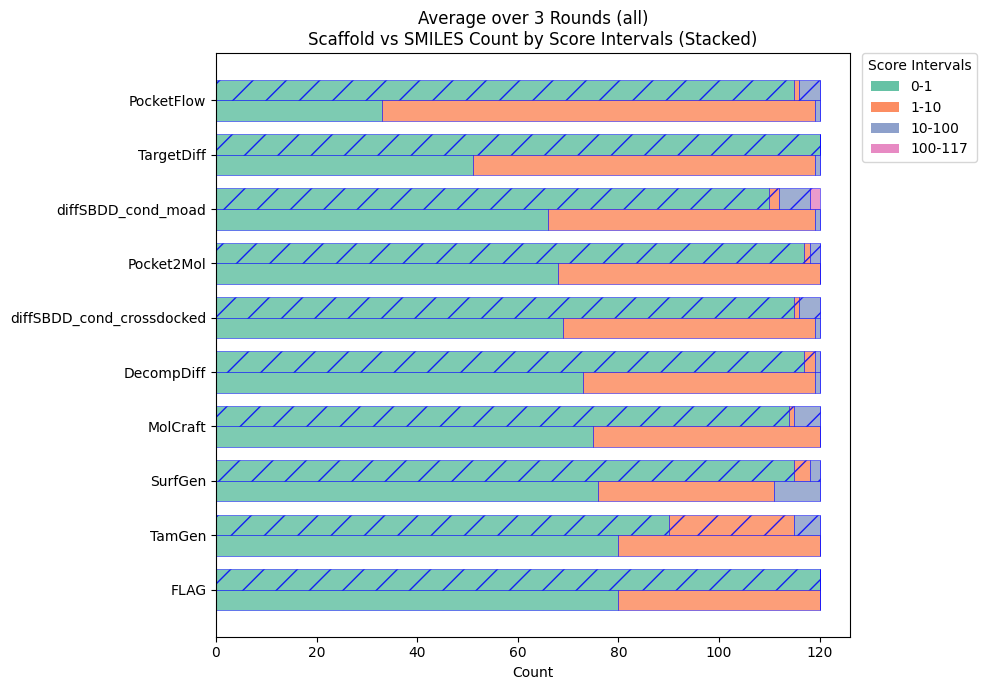

In [39]:
for protein_type in ['seen', 'unseen','all']:
    # 
    # 调用函数生成图像
    for show_values in [True, False]:
        pivot_scf_plot, pivot_smi_plot, _df_scores = get_image_three_repeat_TAScore_counts(round1,round2,round3,crossdock2020_duplicated_uniprotId_map_smiles_in_trainset,protein_type=protein_type,show_values=show_values,image_name='')